## Import dependencies

In [46]:
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import joblib

## Read data

In [47]:
X_train = pd.read_csv("../data/X_train_4.csv",header=[0,1],index_col=0)
X_test = pd.read_csv("../data/X_test_4.csv",header=[0,1],index_col=0)
y_train = pd.read_csv("../data/y_train_4.csv",index_col=0)
y_test = pd.read_csv("../data/y_test_4.csv",index_col=0)

In [48]:
def find_na(df):
    
    features_to_drop = []
    
    for i in df.columns:
        
        if df[i].isna().sum() > len(df)*0.3:
            features_to_drop.append(i)
    
    return features_to_drop

In [49]:
def drop_features(df,features_to_drop):
    
    df.drop(features_to_drop, axis = 1, inplace = True)
    
    return df

### Drop nas

#### Train data

In [50]:
features_to_drop = find_na(X_train)
X_train = drop_features(X_train,features_to_drop)

#### Test data 

In [51]:
X_test = drop_features(X_test,features_to_drop)

## Build pipeline

### Select classifier 

First, I test some classifier, than I can choose one for parameter optimization to get better results.

In [52]:
knc = KNeighborsClassifier()
lr = LogisticRegression(solver="newton-cg")
svc = SVC()
rfc = RandomForestClassifier()
nbc = MultinomialNB()
#gbc = GradientBoostingClassifier()
bc = BaggingClassifier()

ml_models = models = {"knc": knc, "lr": lr, "svc": svc, "rfc": rfc,
                      'nb' : MultinomialNB(),
                       'bc' : BaggingClassifier()}

In [53]:
def initial_model(X_train, X_test, y_train, y_test, ml_models):
    
    
    
    for model in ml_models:
          
        if model != 'nb':
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), (model, ml_models[model])])
        else:
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('minmax',MinMaxScaler()), (model, ml_models[model])])
        
        start_train = time.time()
        pipe.fit(X_train, y_train)
        train_time = round(time.time()-start_train,1)
        
        accuracy = accuracy_score(y_test,pipe.predict(X_test))
        recall = recall_score(y_test,pipe.predict(X_test), average=None)
        precision = precision_score(y_test,pipe.predict(X_test), average=None)
        f1 = f1_score(y_test,pipe.predict(X_test), average=None)
        
        print('*'*20)
        print(f'Scores of {model}:')
        print('*'*20)
        print(f'Train time: {train_time}s')
        print(f'Accuracy score: {accuracy}')
        print('\n')
        print(f'Recall score: {recall}')
        print('\n')
        print(f'Precision score: {precision}')
        print('\n')
        print(f'F1 score: {f1}')
        print('\n')
    

In [54]:
initial_model(X_train,X_test,y_train["activity"],y_test["activity"],ml_models)

********************
Scores of knc:
********************
Train time: 0.6s
Accuracy score: 0.9212927756653992


Recall score: [0.89037433 0.97887324 0.97250859 0.99122807 0.86021505 0.88588589
 0.99693252 0.88888889 0.9375     0.9        0.88       0.68292683
 0.52380952]


Precision score: [0.94468085 0.85276074 0.98951049 0.99559471 0.90566038 0.84045584
 0.98484848 0.88888889 0.9375     0.64285714 0.66666667 0.93333333
 0.73333333]


F1 score: [0.91672402 0.91147541 0.98093588 0.99340659 0.88235294 0.8625731
 0.99085366 0.88888889 0.9375     0.75       0.75862069 0.78873239
 0.61111111]


********************
Scores of lr:
********************
Train time: 11.9s
Accuracy score: 0.9444866920152091


Recall score: [0.91176471 0.97183099 0.9862543  0.99122807 0.94265233 0.9009009
 0.99693252 0.94444444 0.9375     0.8        0.84       0.87804878
 0.95238095]


Precision score: [0.95786517 0.92307692 0.99652778 0.9826087  0.92932862 0.85714286
 0.98784195 0.94444444 1.         0.84210526 

## Final model

In the initial test, in the previous section I tried out some of the classification models in sklearn. There are some model with really high accuracy. Most of the models without any parameter tuning, show us a high accuracy. The fastest model was the `Naive Bayes` but the accuracy wasn't so high. The `Random Forest Classifier` has the highest accuracy score, and the calculation speed is not so bad. I will test out this model. 

### RandomForestClassifier 

In [257]:
rfc_params = {'rfc__n_estimators' : [100],
              'rfc__max_depth' : [2, 20, 50],
              'rfc__min_samples_split' : [2, 5, 10],
              'rfc__min_samples_leaf' : [1, 2, 10]} 

In [258]:
 def random_search(model, params):
        
    pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), ("rfc", model)])
                     
    search = GridSearchCV(pipe, param_grid=params)
    
    return search

In [259]:
model = random_search(RandomForestClassifier(),rfc_params)

In [260]:
model.fit(X_train,y_train['activity'])

GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [2, 20, 50],
                         'rfc__min_samples_leaf': [1, 2, 10],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [100]})

In [262]:
model.best_params_

{'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 5,
 'rfc__n_estimators': 100}

In [55]:
rfc = RandomForestClassifier()
model = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                 ('scaler', StandardScaler()), ("rfc", rfc)])
                     
model.fit(X_train,y_train['activity'])

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier())])

In [56]:
start_train = time.time()
train_time = round(time.time()-start_train,1)

accuracy = accuracy_score(y_test,model.predict(X_test))
recall = recall_score(y_test,model.predict(X_test), average=None)
precision = precision_score(y_test,model.predict(X_test), average=None)
f1 = f1_score(y_test,model.predict(X_test), average=None)

print('*'*20)
print(f'Scores of {model}:')
print('*'*20)
print(f'Train time: {train_time}s')
print(f'Accuracy score: {accuracy}')
print('\n')
print(f'Recall score: {recall}')
print('\n')
print(f'Precision score: {precision}')
print('\n')
print(f'F1 score: {f1}')
print('\n')
    

********************
Scores of Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier())]):
********************
Train time: 0.0s
Accuracy score: 0.9452471482889734


Recall score: [0.92780749 0.95070423 0.97938144 0.98245614 0.96415771 0.91591592
 0.99693252 0.72222222 0.9375     0.8        0.76       0.80487805
 0.85714286]


Precision score: [0.9241012  0.93425606 0.99303136 0.97816594 0.97111913 0.89181287
 0.99085366 0.92857143 1.         0.88888889 0.82608696 0.97058824
 0.7826087 ]


F1 score: [0.92595063 0.94240838 0.98615917 0.98030635 0.9676259  0.9037037
 0.99388379 0.8125     0.96774194 0.84210526 0.79166667 0.88
 0.81818182]




In [43]:
scores = cross_val_score(model, X_train, y_train["activity"], cv=3)

In [44]:
print('Accuracy of the model: {}% ±{}%'.format(round(np.mean(scores)*100,2), round(np.std(scores)*100,2)))

Accuracy of the model: 78.95% ±1.11%


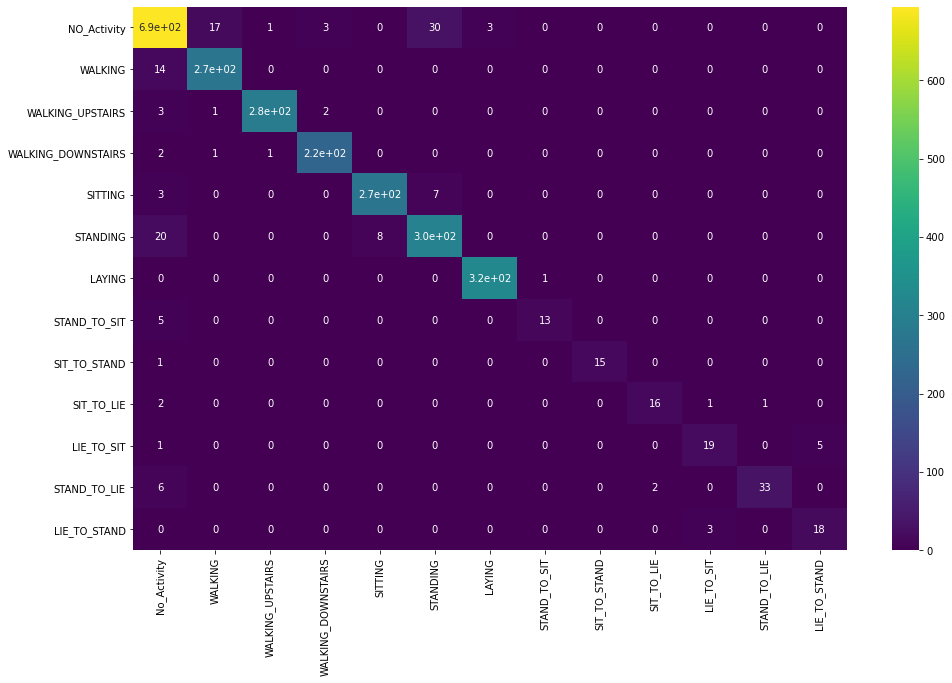

In [57]:
plt.figure(figsize=(16,10))
sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["No_Activity","WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=['NO_Activity',"WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])

###  Saving the final model

In [58]:
import joblib

In [60]:
def save_model():
    '''Save the model to disk'''
    
    filename = '../models/har_model_v06.sav'
    joblib.dump(model, filename)
    readme = open('../models/ml_model_v06.txt', 'w')
    readme.write('Ml model with rfc, there is 50% overlap. Blocks from the original data.')
    readme.close()

In [61]:
save_model()

In [62]:
features_to_drop

[('acc_x_FFT', 'peak_mean_6'),
 ('acc_x_FFT', 'peak_mean_8'),
 ('acc_x_FFT', 'peak_mean_12'),
 ('acc_y_FFT', 'peak_mean_6'),
 ('acc_y_FFT', 'peak_mean_8'),
 ('acc_y_FFT', 'peak_mean_12'),
 ('acc_z_FFT', 'peak_mean_6'),
 ('acc_z_FFT', 'peak_mean_8'),
 ('acc_z_FFT', 'peak_mean_12'),
 ('gyro_x_FFT', 'peak_mean_6'),
 ('gyro_x_FFT', 'peak_mean_8'),
 ('gyro_x_FFT', 'peak_mean_12'),
 ('gyro_y_FFT', 'peak_mean_6'),
 ('gyro_y_FFT', 'peak_mean_8'),
 ('gyro_y_FFT', 'peak_mean_12'),
 ('gyro_z_FFT', 'peak_mean_6'),
 ('gyro_z_FFT', 'peak_mean_8'),
 ('gyro_z_FFT', 'peak_mean_12')]